In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re

In [2]:
DATA_FOLDER = 'data'

In [3]:
dinner_nutrients_df = pd.read_csv('dinner_nutrient.csv')
dinner_ingredients_df = pd.read_csv('dinner_ingredient.csv')

brunch_nutrients_first = pd.read_csv('brunch_nutrient_1-120.csv')
brunch_nutrients_next = pd.read_csv('brunch_nutrient_121-524.csv')
brunch_ingredients_first = pd.read_csv('brunch_ingredient_1-120.csv')
brunch_ingredients_next = pd.read_csv('brunch_ingredient_121-524.csv')

vege_nutrients_df = pd.read_csv('vegetarian_nutrient.csv')
vege_ingredients_df = pd.read_csv('vegetarian_ingredient.csv')

## What we need to do

**Cleaning:**
1. Make quantities of nutrients into integers (while respecting units)
2. Create vegetarian dataset by removing all dishes containing meat or fish-related ingredients (list of words found in the corresponding text documents under /data). If a meat/fish is in ingredients, delete the corresponding recipe from the nutrient dataset.

**Analysis:**
1. Plot histograms of the quantity of a given nutrient thoughout the vegetarian recipes
2. Calculate median and mode (= most common value)
3. Compare these with the FDA recommendation. NOTE this needs to be per serving - verify
4. Calculate median and mode from omnivorous (original) dataset. For large differences with the vegetarian data, also view histogram. Compare together and with FDA.
5. For vegetarian histograms with large discrepencies (some recipes with high levels of nutrient, others with low levels), cross-reference ingredients to see what may be responsible for providing the nutrient.

**Visualization of results:**
1. It would be good to plot the FDA recommendation on the histogram, also median and mode

### Lets explore the data and do some cleaning

In [4]:
dinner_nutrients_df.head(20)

,Unnamed: 0,URL,amount,nutrient,recipe
0,0,https://www.allrecipes.com/recipe/222607/smoth...,20.1g,Total Fat,Smothered Chicken Breasts
1,1,https://www.allrecipes.com/recipe/222607/smoth...,8.0g,Saturated Fat,Smothered Chicken Breasts
2,2,https://www.allrecipes.com/recipe/222607/smoth...,124mg,Cholesterol,Smothered Chicken Breasts
3,3,https://www.allrecipes.com/recipe/222607/smoth...,809mg,Sodium,Smothered Chicken Breasts
4,4,https://www.allrecipes.com/recipe/222607/smoth...,377mg,Potassium,Smothered Chicken Breasts
5,5,https://www.allrecipes.com/recipe/222607/smoth...,16.9g,Total Carbohydrates,Smothered Chicken Breasts
6,6,https://www.allrecipes.com/recipe/222607/smoth...,0.5g,Dietary Fiber,Smothered Chicken Breasts
7,7,https://www.allrecipes.com/recipe/222607/smoth...,44g,Protein,Smothered Chicken Breasts
8,8,https://www.allrecipes.com/recipe/222607/smoth...,15g,Sugars,Smothered Chicken Breasts
9,9,https://www.allrecipes.com/recipe/222607/smoth...,29IU,Vitamin A,Smothered Chicken Breasts


We wonder if the amounts for each nutrient always have the same units. Lets verify with Sodium since this is likely to vary a lot.

In [5]:
dinner_nutrients_df = dinner_nutrients_df.drop(["Unnamed: 0"], axis=1)
dinner_ingredients_df = dinner_ingredients_df.drop(["Unnamed: 0"], axis=1)

In [6]:
sodium = dinner_nutrients_df.where(dinner_nutrients_df['nutrient'] == "Sodium")
sodium = sodium.dropna()
sodium = sodium.reset_index(drop=True)
sodium.head()

,URL,amount,nutrient,recipe
0,https://www.allrecipes.com/recipe/222607/smoth...,809mg,Sodium,Smothered Chicken Breasts
1,https://www.allrecipes.com/recipe/15679/asian-...,711mg,Sodium,Asian Beef with Snow Peas
2,https://www.allrecipes.com/recipe/23847/pasta-...,350mg,Sodium,Pasta Pomodoro
3,https://www.allrecipes.com/recipe/50435/fry-br...,2255mg,Sodium,Fry Bread Tacos II
4,https://www.allrecipes.com/recipe/140829/pork-...,356mg,Sodium,Pork Marsala


The unit is the same for each value of a given nutrient, therefore we can drop these letters without worry.

Vitamin A will be completely ignored since it is given in IU. This unit will no longer be valid from 2021. In addition, it cannot be converted into micrograms since this depends on its origin: retinol (pre-formed vitamin A) or beta-carotene (a precursor).

In [7]:
dinner_nutrients_df = dinner_nutrients_df[dinner_nutrients_df.nutrient != "Vitamin A"]

In [8]:
dinner_nutrients_df.head()

,URL,amount,nutrient,recipe
0,https://www.allrecipes.com/recipe/222607/smoth...,20.1g,Total Fat,Smothered Chicken Breasts
1,https://www.allrecipes.com/recipe/222607/smoth...,8.0g,Saturated Fat,Smothered Chicken Breasts
2,https://www.allrecipes.com/recipe/222607/smoth...,124mg,Cholesterol,Smothered Chicken Breasts
3,https://www.allrecipes.com/recipe/222607/smoth...,809mg,Sodium,Smothered Chicken Breasts
4,https://www.allrecipes.com/recipe/222607/smoth...,377mg,Potassium,Smothered Chicken Breasts


In [9]:
#Remove the letters m, c, g, I, U from the string amount and convert it to a float
dinner_nutrients_df.amount = dinner_nutrients_df.amount.apply(lambda x: re.sub('[mcgIU]','', x))
dinner_nutrients_df.amount = dinner_nutrients_df.amount.replace(to_replace='< 1', value='0')
dinner_nutrients_df.amount = dinner_nutrients_df.amount.astype(float)
dinner_nutrients_df.dtypes

URL          object
amount      float64
nutrient     object
recipe       object
dtype: object

Now lets simplify the datasets

In [10]:
#We can identify recipes by their ID
recipe_id = dinner_ingredients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
dinner_ingredients_df["recipe_id"] = recipe_id
dinner_ingredients_df = dinner_ingredients_df.drop(["URL"], axis=1)
dinner_ingredients_df.head()

,ingredient,recipe_id
0,"4 (6 ounce) skinless, boneless chicken breast ...",222607
1,1/4 teaspoon salt,222607
2,1/4 teaspoon lemon pepper seasoning,222607
3,1 tablespoon vegetable oil,222607
4,8 strips bacon,222607


In [11]:
print("We have: " + str(len(dinner_ingredients_df["recipe_id"].unique())) + " recipes in the ingredient dataframe.")

We have: 1152 recipes in the ingredient dataframe.


In [12]:
recipe_id = dinner_nutrients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
dinner_nutrients_df["recipe_id"] = recipe_id
dinner_nutrients_df.head()

,URL,amount,nutrient,recipe,recipe_id
0,https://www.allrecipes.com/recipe/222607/smoth...,20.1,Total Fat,Smothered Chicken Breasts,222607
1,https://www.allrecipes.com/recipe/222607/smoth...,8.0,Saturated Fat,Smothered Chicken Breasts,222607
2,https://www.allrecipes.com/recipe/222607/smoth...,124.0,Cholesterol,Smothered Chicken Breasts,222607
3,https://www.allrecipes.com/recipe/222607/smoth...,809.0,Sodium,Smothered Chicken Breasts,222607
4,https://www.allrecipes.com/recipe/222607/smoth...,377.0,Potassium,Smothered Chicken Breasts,222607


In [13]:
# let's create a dataframe that contain all the different recipes for dinner with the corresponding name
dinner_recipe_df = dinner_nutrients_df[["recipe_id", "recipe", "URL"]].drop_duplicates()
dinner_recipe_df = dinner_recipe_df.set_index("recipe_id")
print("We have in total: " + str(dinner_recipe_df["recipe"].count()) + " different recipes with nutrition info\
      for dinner")
dinner_recipe_df.head()

We have in total: 1128 different recipes with nutrition info      for dinner


,recipe,URL
recipe_id,,
222607,Smothered Chicken Breasts,https://www.allrecipes.com/recipe/222607/smoth...
15679,Asian Beef with Snow Peas,https://www.allrecipes.com/recipe/15679/asian-...
23847,Pasta Pomodoro,https://www.allrecipes.com/recipe/23847/pasta-...
50435,Fry Bread Tacos II,https://www.allrecipes.com/recipe/50435/fry-br...
140829,Pork Marsala,https://www.allrecipes.com/recipe/140829/pork-...


In [14]:
dinner_nutrients_df = dinner_nutrients_df.drop(["URL", "recipe"], axis=1)
dinner_nutrients_df.head()

,amount,nutrient,recipe_id
0,20.1,Total Fat,222607
1,8.0,Saturated Fat,222607
2,124.0,Cholesterol,222607
3,809.0,Sodium,222607
4,377.0,Potassium,222607


We see that there are recipes that did not give the nutrient values. We ignore these ones by putting exclusively recipe IDs present in the nutrient dataframe into the dataframe linking recipes with URL and name.

**Now we can clean our other datasets easily **

In [15]:
def clean_data(nutrients_df, ingredients_df):
    """
    After exploration, we create a general function to clean all subsequent datasets
    IN: nutrient and ingredient information, in dataframes
    OUT: cleaned nutrient and ingredient dataframes + a new dataframe linking the URL, ID, and name of recipes
    """
    
    nutrients_df = nutrients_df.drop(["Unnamed: 0"], axis=1)
    ingredients_df = ingredients_df.drop(["Unnamed: 0"], axis=1)
    
    #Drop vitamin A
    nutrients_df = nutrients_df[nutrients_df.nutrient != "Vitamin A"]
    
    #Remove the letters m, c, g, I, U from the string amount and convert it to a float
    nutrients_df.amount = nutrients_df.amount.apply(lambda x: re.sub('[mcgIU]','', x))
    nutrients_df.amount = nutrients_df.amount.replace(to_replace='< 1', value='0')
    nutrients_df.amount = nutrients_df.amount.astype(float)
    
    #Identification with ID
    recipe_id = ingredients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
    ingredients_df["recipe_id"] = recipe_id
    ingredients_df = ingredients_df.drop(["URL"], axis=1)
    
    recipe_id = nutrients_df["URL"].str.extract(r'https://www.allrecipes.com/recipe/(\d+)/.+')
    nutrients_df["recipe_id"] = recipe_id
    
    #Dataframe linking ID with URL and recipe name
    recipe_df = nutrients_df[["recipe_id", "recipe", "URL"]].drop_duplicates()
    recipe_df = recipe_df.set_index("recipe_id")
    
    nutrients_df = nutrients_df.drop(["URL", "recipe"], axis=1)
    
    return nutrients_df, ingredients_df, recipe_df

In [16]:
brunch_nutrients_df = brunch_nutrients_first.append(brunch_nutrients_next)
brunch_ingredients_df = brunch_ingredients_first.append(brunch_ingredients_next)
brunch_recipes = []

In [17]:
brunch_nutrients_df, brunch_ingredients_df, brunch_recipes = clean_data(brunch_nutrients_df, brunch_ingredients_df)

In [18]:
vege_recipes = []
vege_nutrients_df, vege_ingredients_df, vege_recipes = clean_data(vege_nutrients_df, vege_ingredients_df)

### Nutrient histograms for vegetarian meals

In [19]:
def nutrient_histogram(nutrients_df, name):
    """
    Plot a histogram with the amount for a specified nutrient
    IN: nutrient dataframe and name of the nutrient we want to plot
    OUT: histogram with 20 bins for 'amount'
    """
    nutrient = nutrients_df.where(nutrients_df['nutrient'] == name)
    nutrient = nutrient.dropna()
    nutrient = nutrient.reset_index(drop=True)
    
    graph = nutrient.hist(column='amount', bins=20);
    plt.title(n)
    return graph

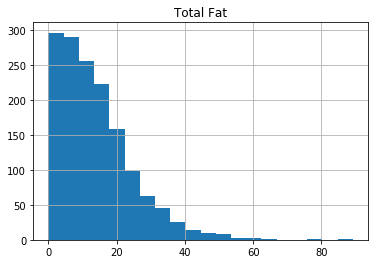

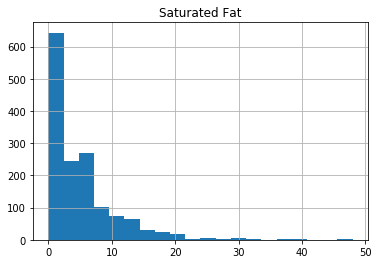

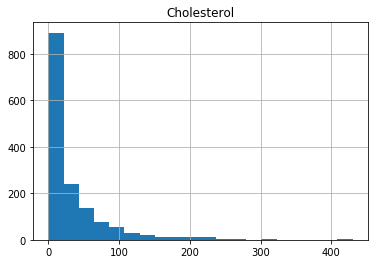

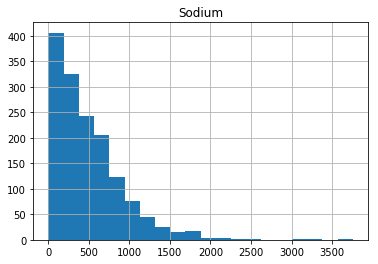

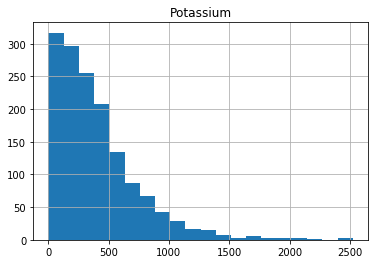

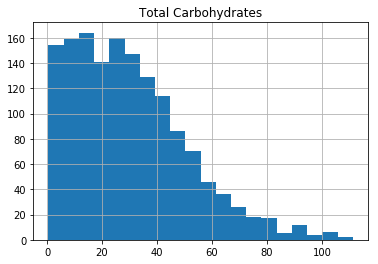

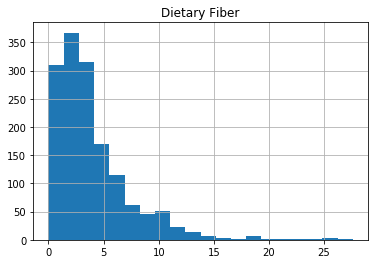

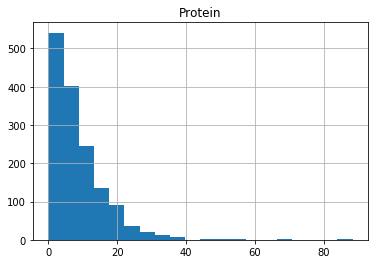

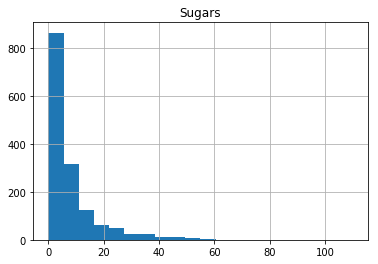

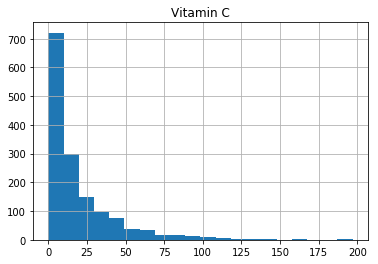

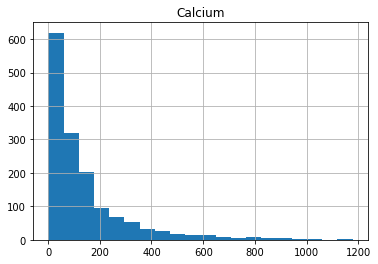

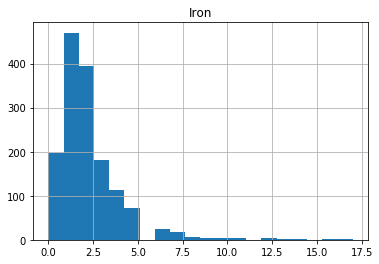

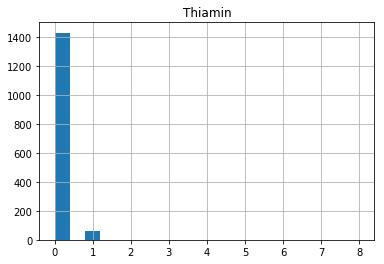

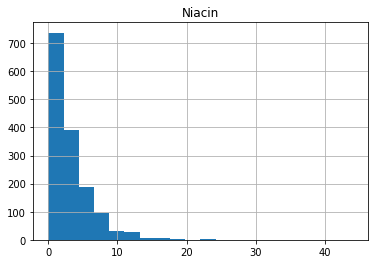

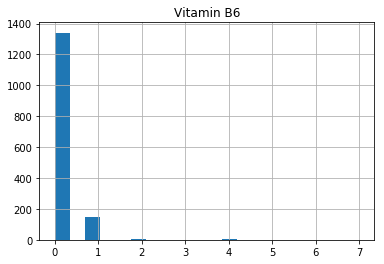

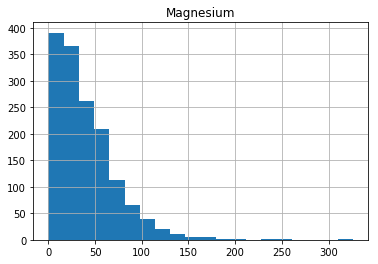

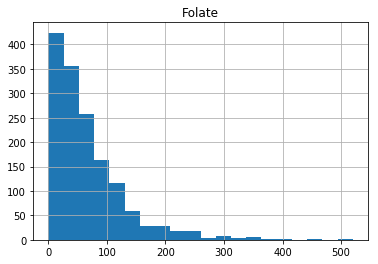

In [20]:
nutrient_list = vege_nutrients_df['nutrient'].unique()
for n in nutrient_list:
    nutrient_histogram(vege_nutrients_df, n);